## Using Random Forest

### Importing useful libraries

In [404]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

from matplotlib import cm

from matplotlib import font_manager
font_path = 'C://Users//amita//AppData//Local//Microsoft//Windows//Fonts/Barlow-Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [405]:
data = pd.read_csv('chowdary.csv', index_col=0)

y = data['tumour']
X = data.drop('tumour', axis=1)

In [406]:
# Fit the model
clf = RandomForestClassifier(n_estimators=10000, max_depth=6, max_features=10)

clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_

# Get the indices of the most important features
indices = np.argsort(importances)[::-1]

### Calculating F1 Score

In [407]:
from sklearn.metrics import f1_score

f1_score(y.values, clf.predict(X), average="binary", pos_label="B")

1.0

### Feature importance

In [408]:
forest_importances = pd.Series(clf.feature_importances_, index=X.columns)
forest_importances_sorted = forest_importances.sort_values(ascending=False)

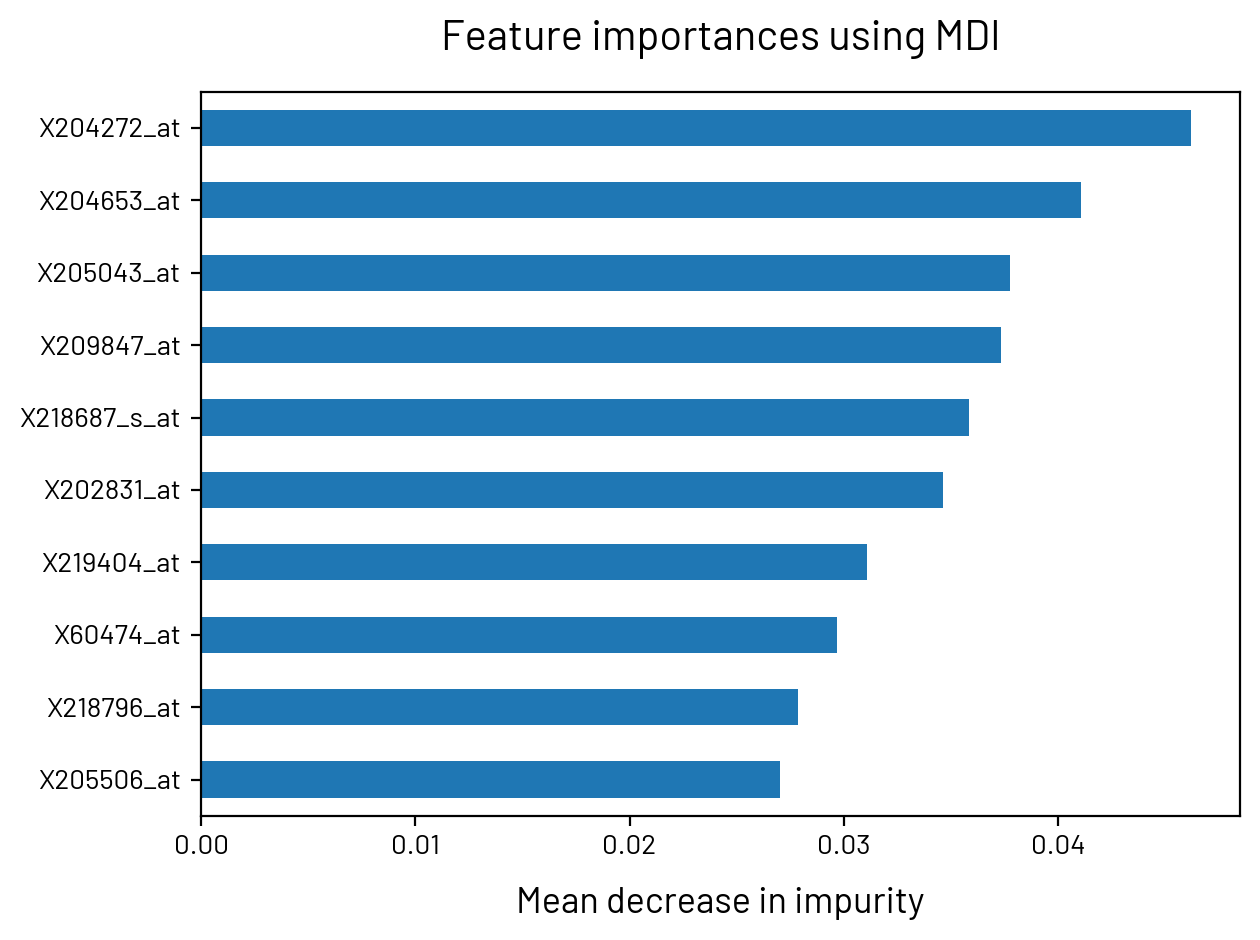

In [409]:
fig, ax = plt.subplots(dpi=200)
forest_importances_sorted[:10].plot.barh(ax=ax)
plt.gca().invert_yaxis()
ax.set_title("Feature importances using MDI", fontsize=15, pad=15)
ax.set_xlabel("Mean decrease in impurity", fontsize=13, labelpad=10)
plt.tick_params(labelsize=10)
fig.tight_layout()

## Even though Random Forest doesn't require cross validation but still too see it's performance

In [440]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Set up the values of alpha to test
alpha = 0.1

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []

model = RandomForestClassifier(n_estimators=10000, max_depth=6, max_features=10)

# Loop over the different folds
for train_idx, val_idx in kf.split(X):
    # Split the data into training and validation sets for this fold
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Fit the model on the training set for this fold and alpha value
    model.fit(X_train, y_train)

    # Calculate and add f1 score on validation set
    y_val_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_val_pred, pos_label='B'))

In [441]:
f1_scores

[0.9600000000000001,
 0.9655172413793104,
 1.0,
 0.9565217391304348,
 0.9523809523809523]

In [442]:
np.mean(f1_scores)

0.9668839865781396

# Extra work (not talked about in the report)

## Permutation Importance with Multicollinear or Correlated Features 

In [352]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [353]:
y = data['tumour']
X = data.drop('tumour', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.91


## Next, we plot the tree based feature importance and the permutation importance

In [354]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

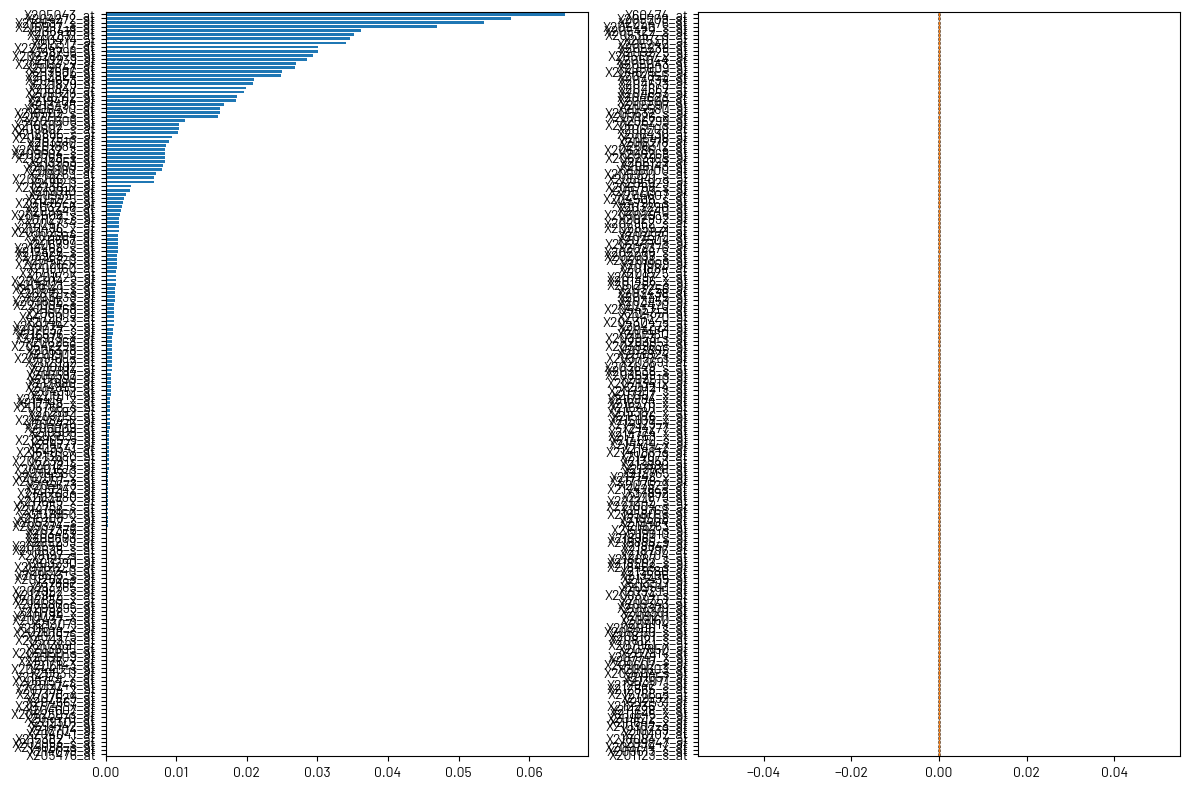

In [355]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

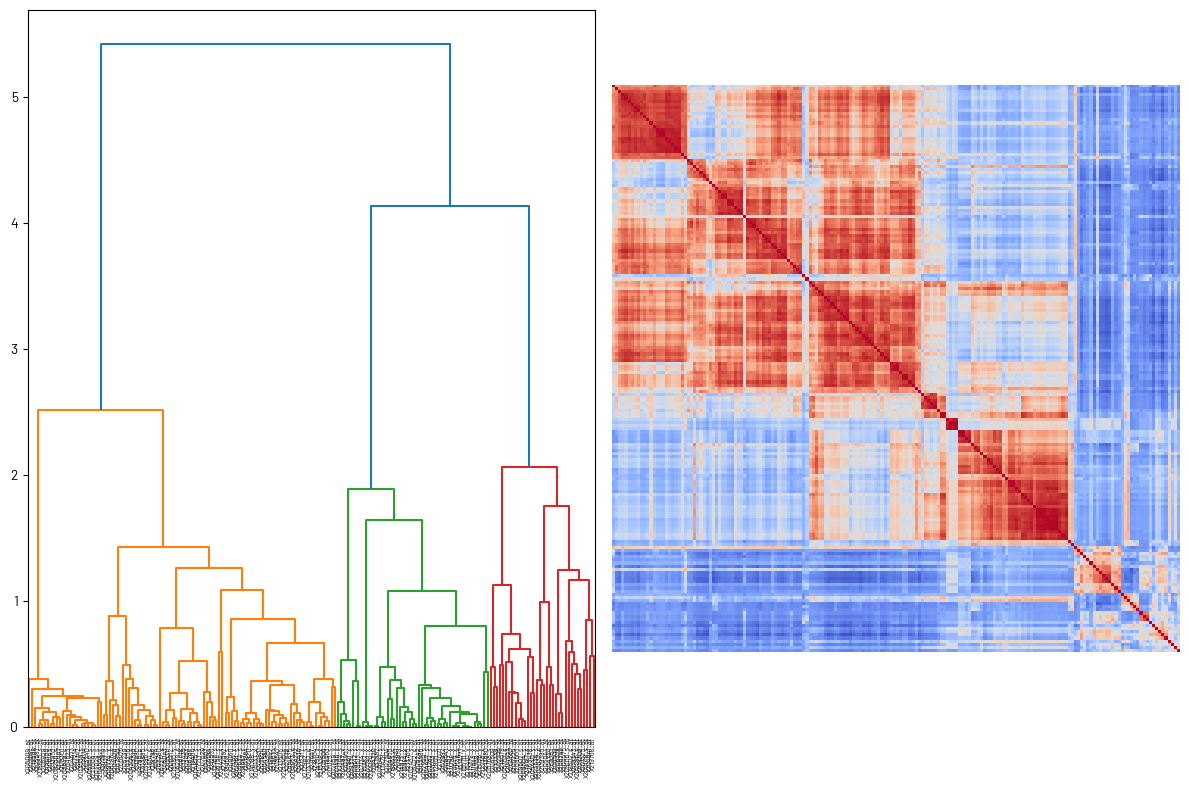

In [356]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# corr = spearmanr(X).correlation
corr = X.corr().values

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(dist_linkage, labels=X.columns.tolist(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap='coolwarm')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
ax2.axis('off')
fig.tight_layout()
plt.show()

In [389]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train.values[:, selected_features]
X_test_sel = X_test.values[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 1.00


In [392]:
X.columns[selected_features]

Index(['X201123_s_at', 'X201262_s_at', 'X201496_x_at', 'X201525_at',
       'X201909_at', 'X202037_s_at', 'X202286_s_at', 'X202376_at',
       'X203029_s_at', 'X203256_at', 'X203290_at', 'X205509_at', 'X206378_at',
       'X206754_s_at', 'X207134_x_at'],
      dtype='object')